# 라이브러리 불러오기 & 파일 읽기 준비

## 라이브러리 불러오기

In [2]:
%%capture
! pip install -U colorama

In [3]:
from google.colab import drive

import pickle
from glob import glob
from tqdm.notebook import tqdm
from pprint import pprint
import gc; gc.enable()

from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from colorama import Fore, Back, Style

ROOT = '/content/drive/'; drive.mount(ROOT)
PATH = f'{ROOT}/MyDrive/Dacon/GrowRegression/'

%cd $PATH
%ls

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1xwyT2VNzWX8ilYppxpO9oeeGzeFniDyZ/GrowRegression
data/  Notebook/  output/  reference/  submission/


## 파일 읽기 준비

In [4]:
with open('reference/columnDictionary.pkl', 'rb') as F:
    colDict = pickle.load(F)

reverse_colDict = {v:k for k, v in colDict.items()}

pprint(colDict)

{'CO2관측치': 'CO2',
 'EC관측치': 'EC',
 '기준온도': 'refTemp',
 '난방부하': 'HeatingLoad',
 '난방상태': 'HeatingState',
 '난방온도': 'HeatingTemp',
 '난방작동남은시간': 'HeatingRemains',
 '내부습도관측치': 'innerHum',
 '내부온도관측치': 'innerTemp',
 '내부유동팬상태': 'innerFanState',
 '내부유동팬작동남은시간': 'innerFanRemains',
 '냉방부하': 'CoolingLoad',
 '냉방상태': 'CoolingState',
 '냉방온도': 'CoolingTemp',
 '냉방작동남은시간': 'CoolingRemains',
 '레드 LED동작강도': 'RedLEDStrength',
 '레드 LED상태': 'RedLEDState',
 '레드 LED작동남은시간': 'RedLEDRemains',
 '백색광추정광량': 'WhiteLight',
 '블루 LED동작강도': 'BlueLEDStrength',
 '블루 LED상태': 'BlueLEDState',
 '블루 LED작동남은시간': 'BlueLEDRemains',
 '시간': 'time',
 '외부습도관측치': 'outerHum',
 '외부습도추정관측치': 'outerHum',
 '외부온도관측치': 'outerTemp',
 '외부온도추정관측치': 'outerTemp',
 '외부환기팬상태': 'outerFanState',
 '외부환기팬작동남은시간': 'outerFanRemains',
 '일간누적분무량': 'cumSprayAmnt',
 '적색광추정광량': 'RedLight',
 '청색광추정광량': 'BlueLight',
 '총추정광량': 'TotalLight',
 '최근분무량': 'recentSprayAmnt',
 '카메라상태': 'CameraState',
 '펌프상태': 'PumpState',
 '펌프일간누적분무량': 'cumSprayAmnt',
 '펌프작동남은시간': 'Pump

In [6]:
trainList = sorted(glob('data/data_raw/train_input/*.csv'))
testList = sorted(glob('data/data_raw/test_input/*.csv'))
labelList = sorted(glob('data/data_raw/train_target/*.csv'))

# 파일 살펴보기 

- 각 파일의 길이, 변수의 개수가 일정한지 확인

## 학습 / 테스트 데이터

In [7]:
for _ in trainList + testList:
    print(f"{_.split('/')[-2].split('_')[0].upper()} {_.split('/')[-1].split('.')[0].split('_')[1]}")
    __ = pd.read_csv(_, parse_dates=['시간']).rename(columns = colDict).set_index('time')
    print(f"Shape : {__.shape}")
    print(f"Days : {len(__.resample('D'))}")
    print('*'*100)

TRAIN 01
Shape : (41760, 37)
Days : 29
****************************************************************************************************
TRAIN 02
Shape : (41760, 37)
Days : 29
****************************************************************************************************
TRAIN 03
Shape : (38880, 37)
Days : 27
****************************************************************************************************
TRAIN 04
Shape : (41760, 37)
Days : 29
****************************************************************************************************
TRAIN 05
Shape : (41760, 37)
Days : 29
****************************************************************************************************
TRAIN 06
Shape : (41760, 37)
Days : 29
****************************************************************************************************
TRAIN 07
Shape : (41760, 37)
Days : 29
****************************************************************************************************
TRAIN 08
Shape : (41

## 라벨



In [8]:
for _ in labelList:
    print(f"{_.split('/')[-2].split('_')[0].upper()} {_.split('/')[-1].split('.')[0].split('_')[1]}")
    __ = pd.read_csv(_, parse_dates=['시간']).set_index('시간')
    print(f"Days : {__.shape[0]}")
    print('*'*100)

TRAIN 01
Days : 29
****************************************************************************************************
TRAIN 02
Days : 29
****************************************************************************************************
TRAIN 03
Days : 27
****************************************************************************************************
TRAIN 04
Days : 29
****************************************************************************************************
TRAIN 05
Days : 29
****************************************************************************************************
TRAIN 06
Days : 29
****************************************************************************************************
TRAIN 07
Days : 29
****************************************************************************************************
TRAIN 08
Days : 29
****************************************************************************************************
TRAIN 09
Days : 47
*********************

## Note

- *Note 1.* 변수의 개수는 동일하나 재배 일자 수가 다름
- *Note 2.* 학습에 있어서 신경망보다는 Decision Tree 계열이 유용할 것으로 고려됨
    - 변수를 Aggregation 하는 것을 고려 ➡ 라벨의 경우 일자별로 집계되어 있음
- *Note 3.* 신경망 모형 적용시 빈 데이터를 추가하여야 함을 유의.
- *Note 4.* 실제 성장이 일어나는 구간을 찾아내어 학습시키는 방법도 존재.
- *Note 5.* Train - Validation을 나눌 때에 Case 단위로 분리해야 함

# 변수 살펴보기
- Appoach
    - 주어진 데이터가 무엇을 의미하는지에 대한 추가적인 정보가 없음
    - 범주형 변수를 우선적으로 찾을 필요성이 있음
    - 변수명에 비추어 볼 때, ***~상태***는 측정 장비의 상태를 의미 할 가능성이 있음
    - ***남은시간***의 경우 연속형 변수일 수 있으나, 실험 장비는 일정한 셋팅으로 움직이므로 실제 값은 범주형처럼 설정되어있을 수 있음.

- 모든 파일에 대해서 값을 확인 할 필요가 있음
- 결측치가 존재하는지 확인야함
- 43번 Train-Label 데이터 간에 하루 차이가 있음을 확인 ➡ train 데이터에서 초기 하루 삭제 할 필요가 있음.

## 준비

In [ ]:
# 변수 :: 상태
featState = [x for x in set(colDict.values()) if x.endswith('State')]

# 변수 :: 남은 시간 
featRemains = [x for x in set(colDict.values()) if x.endswith('Remains')]

# 나머지 모든 변수
feats = [x for x in set(colDict.values()) if x not in featState and x not in featRemains + ['time']]

In [ ]:
train = pd.DataFrame()
na_count = pd.DataFrame()
for idx, fileName in tqdm(enumerate(trainList), total=len(trainList)):
    F = pd.read_csv(fileName, parse_dates=['시간'])
    if '펌프작동남은시간.1' in F.columns:
        F = F.rename(columns={'펌프작동남은시간.1':'펌프최근분무량',
                             '최근분무량' : '일간누적분무량'
                             })

    F = F.rename(columns=colDict)
    F.insert(loc=1, column='ID', value=[idx+1]*len(F))

    train = pd.concat([train, F]).reset_index(drop=True)
    na_count = pd.concat([na_count, pd.DataFrame(F.isna().sum(), columns=[f'file_{idx+1}'])], axis=1)

na_count = na_count.transpose()\
                .drop(['time', 'ID'], axis=1)\
                .reset_index()\
                .rename(columns={'index':'fileName'})\
                .set_index('fileName')

na_count['Total'] = na_count.sum(axis=1).astype('int64')
na_total = na_count['Total']

na_count = na_count[na_count['Total'] > 1000].drop('Total', axis=1)

  0%|          | 0/58 [00:00<?, ?it/s]

## 결측치

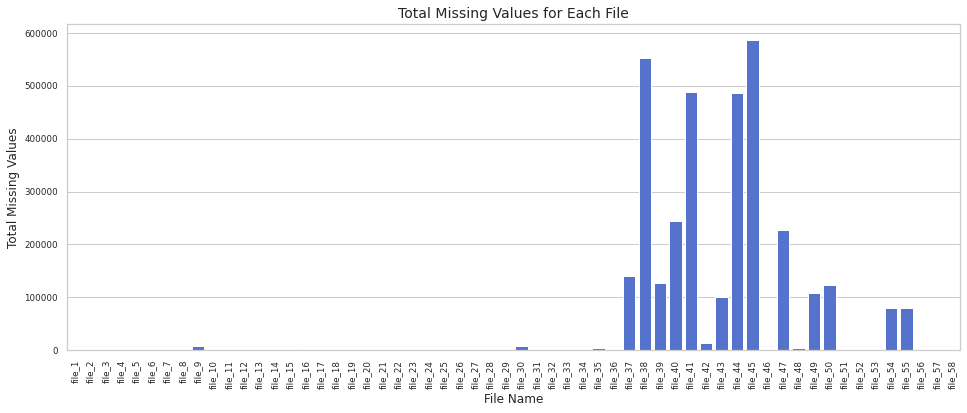

In [ ]:
plt.figure(figsize=(16, 6))

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale = 0.8)

p = sns.barplot(x=na_total.index, y=na_total.values,
            order = na_total.index.values,
            color = "royalblue"
            )
p.set_xticklabels(na_total.index.values, rotation=90)
p.set_title("Total Missing Values for Each File", fontsize=14)
p.set_xlabel("File Name", fontsize=12)
p.set_ylabel("Total Missing Values", fontsize=12)
plt.show()

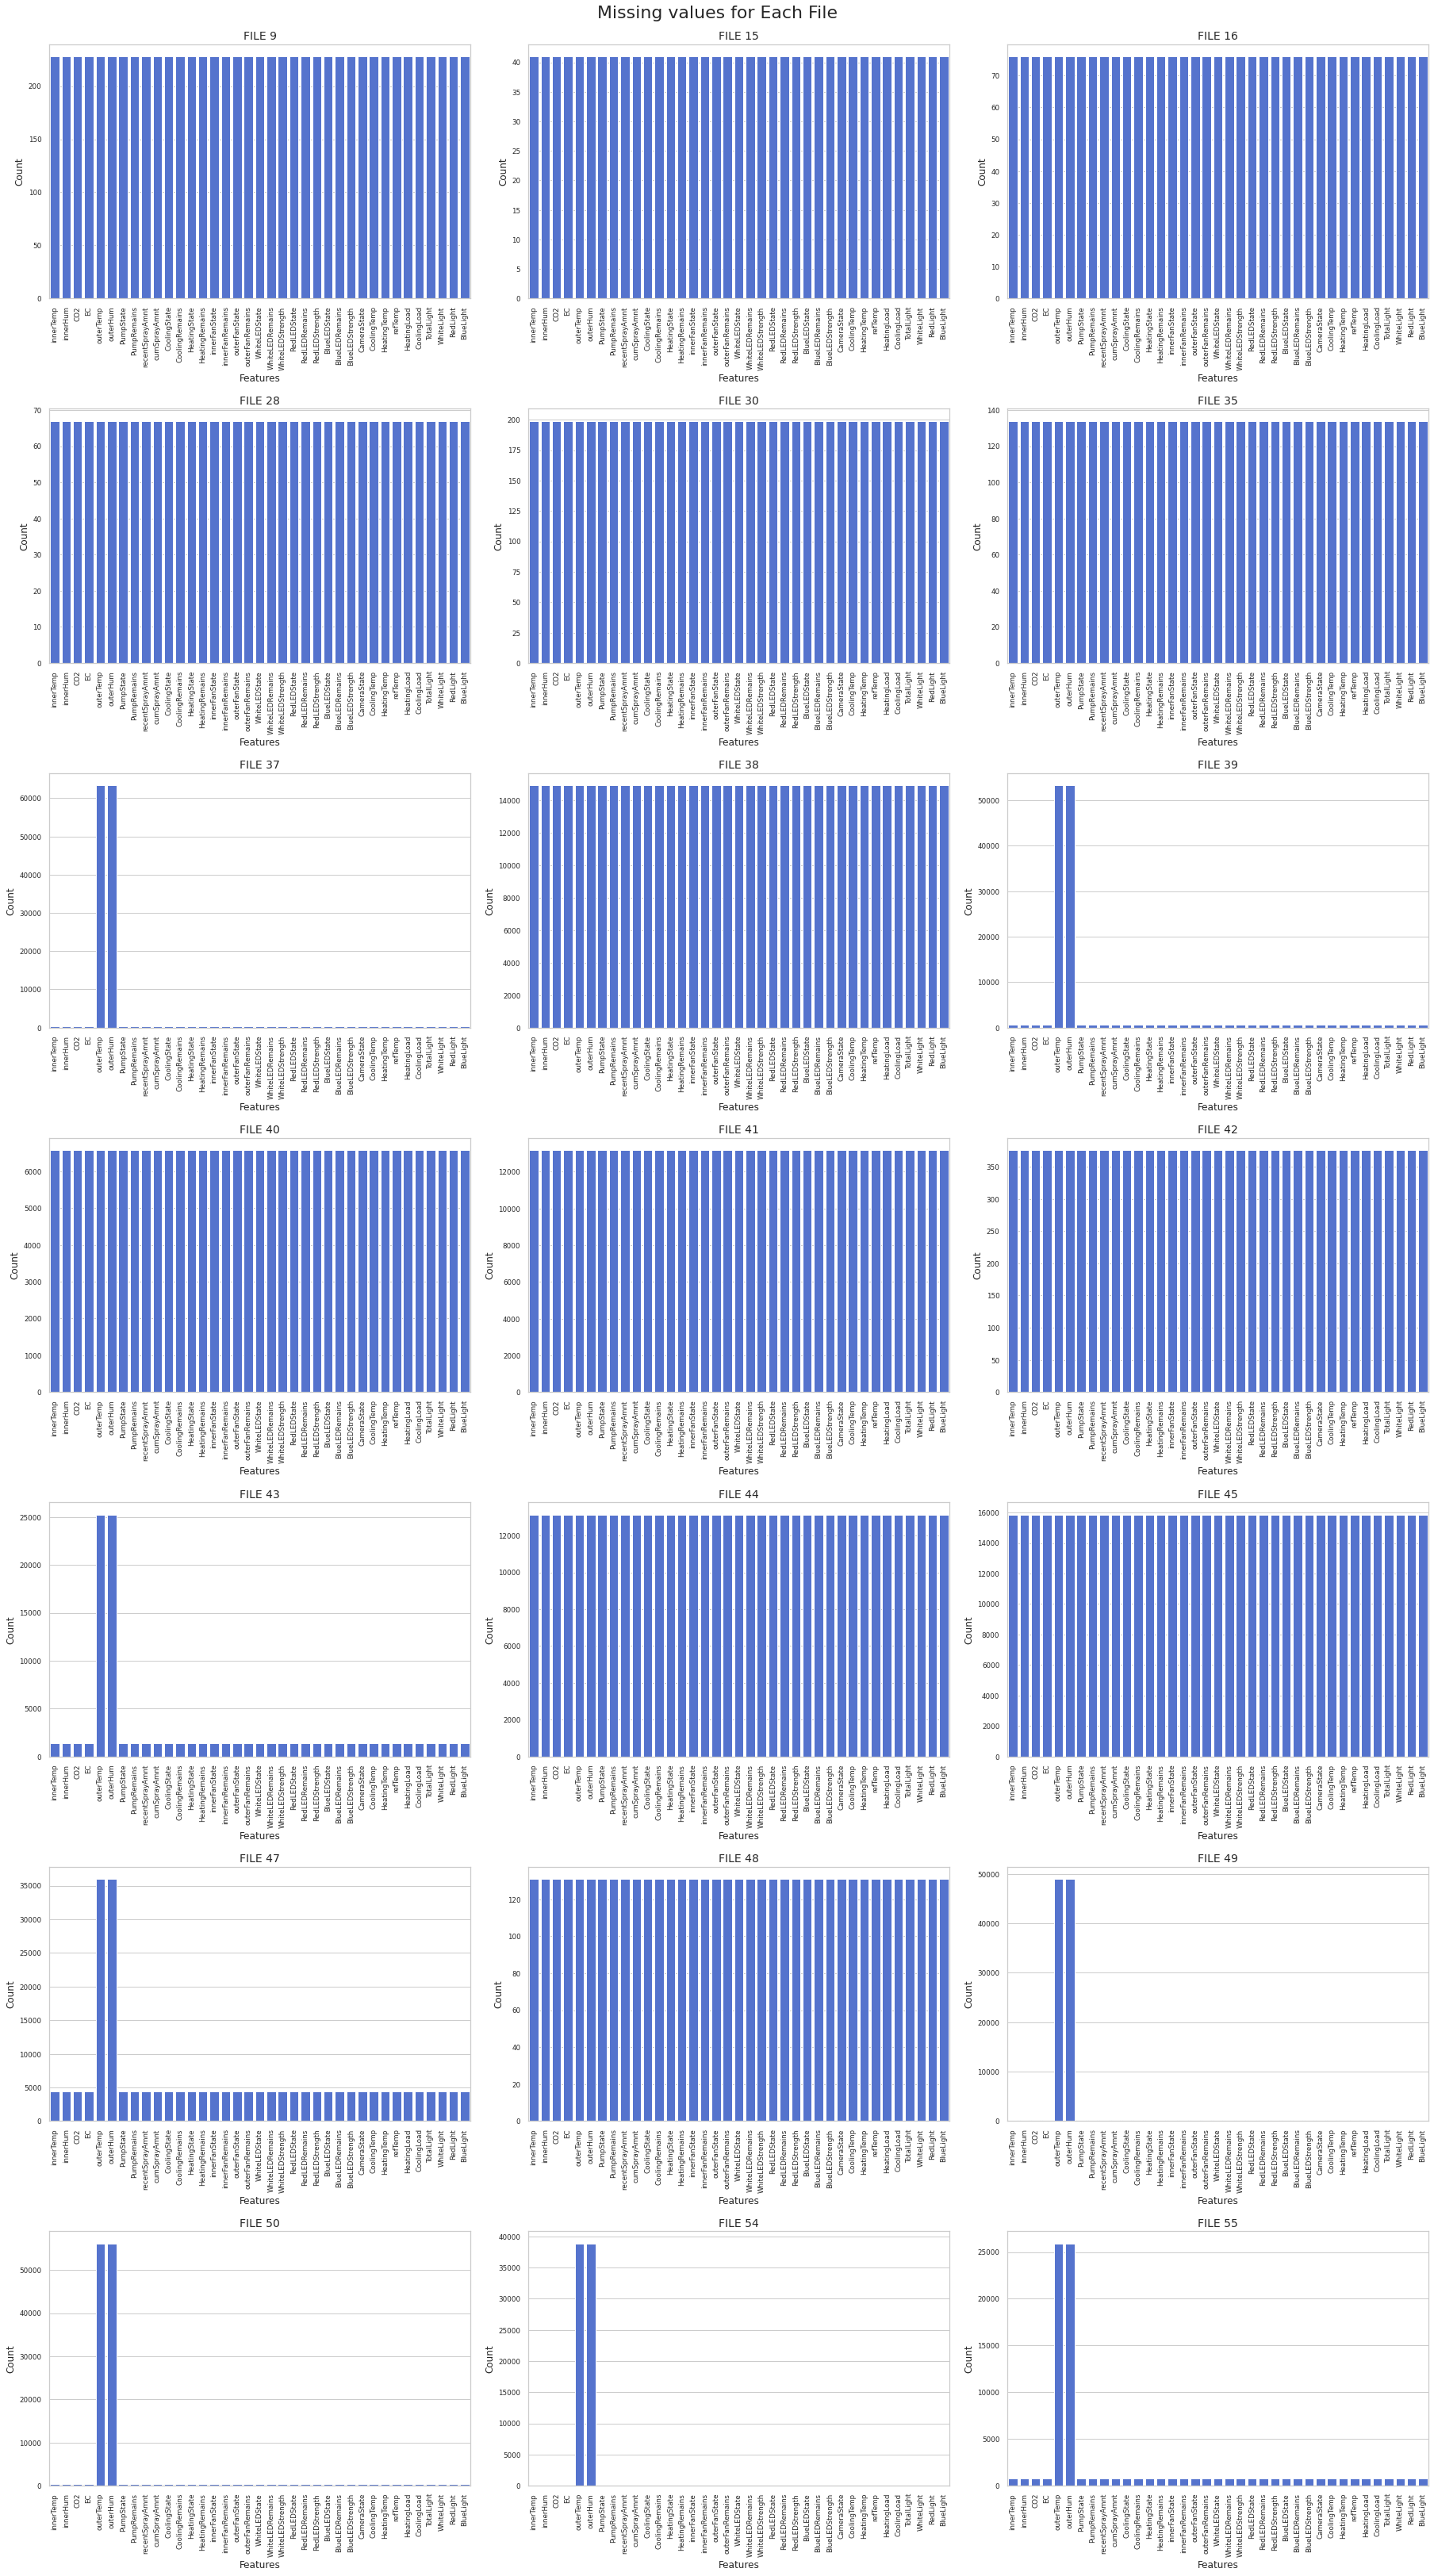

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(5*5, 9*5),
                         constrained_layout = True)

fig.suptitle("Missing values for Each File", fontsize=22)

plotIdx = iter(list(product([_ for _ in range(7)], [_ for _ in range(3)])))

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale = 0.8)

for idx, row in na_count.iterrows():
    i, j = next(plotIdx)

    p = sns.barplot(x=row.index, y=row.values, 
                    order=row.index.values,
                    color="royalblue",
                    ax=axes[i][j])
    
    axes[i][j].set_xticklabels(row.index.values, rotation=90)

    axes[i][j].set_title(f"{' '.join(idx.split('_')).upper()}",
                         fontsize=14)
    axes[i][j].set_xlabel("Features", fontsize=12)
    axes[i][j].set_ylabel("Count", fontsize=12)

plt.show()

- 구조적 결측치(structurally missing) : 각 데이터에서 동일한 양의 데이터가 삭제된 것으로 고려 할 때, 의도적으로 정해진 양의 데이터가 탈락했을 가능성이 있음. 
- 결측치가 특정 파일에 몰려있으므로 train-valid split에 반영해야 할 수 있음.
- 결측치가 존재하므로 데이터 타입을 변경시 null-able로 사용 (ex. int64)

In [ ]:
sns.reset_orig()

# 데이터 세부 확인

- raw 데이터에서는 float64로 설정되어있음
- 소수점 단위를 포함하는 경우에는 기존 형태를 유지해야함
- 정수만으로 구성되어있다면 메모리 관리 차원에서 자료형을 변환
- float64의 경우 데이터 변환 과정에서 동일한 0으로 처리가 되지 않고 1e-63, 3e-55 등으로 처리되었을 가능성이 있음 (floating point)
- 범주형 변수를 탐색
- Noise injection 가능성 고려 ➡ unique value의 개수가 변하지 않는 선에서 n번째 자리까지 반올림

In [ ]:
x = [i for i in range(1, 10)]
print(x)
print(sorted(x, reverse=True))

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[9, 8, 7, 6, 5, 4, 3, 2, 1]


In [ ]:
def progressiveRounding(dataset:pd.DataFrame, featureList:list, decimal_from:int, decimal_to:int):
    for feat in featureList:
        print(f"{Fore.GREEN}{Style.BRIGHT}Current Feature : {feat}{Style.RESET_ALL}")
        
        print(f"{Fore.BLUE}{Style.BRIGHT}Before Rounding{Style.RESET_ALL}")
        F = dataset[feat]
        print(f"{Fore.RED}{Style.BRIGHT}{len(F.unique())} values{Style.RESET_ALL}")
        print(*sorted(F.unique())[:200])
        print(f"Min :{F.min()}\nMax : {F.max()}\nMean :{F.mean()}")

        for decimal in range(decimal_from, decimal_to-1, -1):
            print(f"{Fore.BLUE}{Style.BRIGHT}After Rounding to decimal point {decimal}{Style.RESET_ALL}")
            F = F.apply(round, args=(decimal, ))
            print(f"{Fore.RED}{Style.BRIGHT}{len(F.unique())} values{Style.RESET_ALL}")
            print(*sorted(F.unique())[:200])
            print(f"Min :{F.min()}\nMax : {F.max()}\nMean :{F.mean()}")
            
        print("*"*200)

        del F; gc.collect()

# 남은시간 

In [ ]:
progressiveRounding(train, featRemains, decimal_from=3, decimal_to=0)

Current Feature : CoolingRemains
Before Rounding
18970 values
0.0 0.1038751345533058 0.1578947368421098 0.2051282051282044 0.2077502691065831 0.3116254036598605 0.3157894736842195 0.4102564102564088 0.4155005382131378 0.473684210526315 0.5 0.5193756727664152 0.6153846153846132 0.6232508073197209 0.6315789473684248 0.666666666666667 0.7271259418729983 0.7894736842105345 0.8205128205128176 0.8310010764262756 0.9101152368762088 0.934876210979553 0.94736842105263 1.0 1.025641025641022 1.03875134553283 1.10526315789474 1.142626480086136 1.210341805433927 1.230769230769241 1.246501614639413 1.26315789473685 1.333333333333334 1.350376749192691 1.421052631578959 1.435897435897445 1.446556822982984 1.454251883745968 1.558127018299245 1.578947368421055 1.641025641025649 1.662002152852551 1.736842105263165 1.765877287405829 1.846153846153854 1.869752421959106 1.894736842105274 1.973627556512383 2.051282051282058 2.05263157894737 2.077502691065661 2.181377825618966 2.21052631578948 2.2564102564102

# 상태

In [ ]:
progressiveRounding(train, featState, decimal_from=3, decimal_to=0)

Current Feature : outerFanState
Before Rounding
1998 values
0.0 0.5 1.0 25.5 29.0 29.5 30.0 30.5 33.0 34.0 34.5 37.5 44.0 51.0 55.0 56.0 58.0 59.0 59.5 60.0 61.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 75.0 79.0 81.0 82.0 83.0 84.0 85.0 88.0 89.0 96.0 97.0 100.0 101.0 102.0 103.0 103.5 104.0 105.0 106.0 107.0 109.0 110.0 111.0 112.0 113.0 114.0 114.5 116.0 117.0 118.0 119.0 134.0 201.0 nan 0.108122646584178 0.2162452931683561 0.3243679397525341 0.4324905863367405 0.5406132329209186 0.6487358795050966 0.7568585260892746 0.8649811726734811 0.9731038192576592 1.081226465841837 1.189349112426015 1.297471759010222 1.4055944055944 1.513717052178578 1.621839698762756 1.729962345346962 1.83808499193114 1.946207638515318 2.054330285099496 2.162452931683703 2.270575578267881 2.378698224852059 2.486820871436237 2.594943518020443 2.703066164604621 2.811188811188799 2.919311457772977 3.027434104357184 3.135556750941362 3.24367939752554 3.351802044109718 3.459924690693924 3.568047337278102 3.6761699

# Note. Remains / State



- Remains / State 
    - 소수점 세번째 자리에서 반올림 할 경우 unique values의 개수에 큰 변화를 보이지 않음 ➡ 소수점 세번째 자리까지 반올림
    - 신호를 처리하는 장치가 무엇인지는 알 수 없으나, 값의 범위는 0~201으로 추정되며, 그 이상의 값의 경우 의도적으로 입력된 outlier로 추정됨
        - 식물재배실험에 사용되는 장비의 경우 MIT Media Lab Open Agriculture Initiative (OpenAg)의 시스템을 기반으로하는 경우가 많고, 해당 데이터의 계측도 이와 유사한 것으로 확인됨.
        - anomaly detection 알고리즘을 통해 이상치들을 처리 할 필요가 있음

# 그 외 변수

In [ ]:
progressiveRounding(train, feats, decimal_from=5, decimal_to=0)

Current Feature : recentSprayAmnt
Before Rounding
125 values
0.0 10.26 16.69 23.12 29.55 35.98 42.41 48.84 55.27 61.7 68.13 74.55999999999999 74.56 80.99 87.42 93.85 100.28 106.71 113.14 119.57 126.0 132.43 138.86 145.29 151.72 158.15 164.58 171.01 177.44 183.87 190.3 196.73 222.45 254.6 299.61 318.9 325.33 344.62 357.48 363.91 370.34 376.77 383.2 384.5 389.6299999999999 389.63 396.0599999999999 396.06 402.49 408.92 415.35 421.78 428.21 434.64 441.07 447.4999999999999 447.5 453.9299999999999 453.93 460.36 466.79 473.22 479.65 486.08 492.5099999999999 492.51 498.9399999999999 498.94 505.3699999999999 505.37 511.8 518.23 524.66 531.09 537.52 543.95 550.38 556.81 556.8100000000001 563.24 569.67 576.1 582.53 588.96 595.39 601.82 608.25 614.68 621.11 627.54 633.97 640.4 646.83 653.26 659.69 666.12 672.55 678.98 685.41 691.84 698.27 704.7 711.13 717.56 717.5600000000001 723.99 730.42 736.85 743.28 749.71 756.14 762.57 769.0 nan 775.43 642656.61 642675.9 642836.65 642913.81 642926.67 642939.5

# Note. 나머지 변수



- 특정 값 범위를 넘어가는 경우에 임의로 값이 대치된 것으로 보임
    - 직접 값을 변형하기보다는 anomaly detection 알고리즘을 통해서 처리
- 소수점 자리에 따라 unique value의 숫자가 큰 차이를 보이지 않는 경우를 임의로 정의하면 다음과 같음

```
    cont_int = ['recentSprayAmnt']
    cont_1st = ['cumSprayAmnt']
    cont_2nd = ['BlueLEDStrength', 'RedLEDStrength', 'WhiteLEDStrength']
    cont_3rd = ['BlueLight', 'WhiteLight', 'RedLight', 'TotalLight', 'CO2']
    cont_4th = ['CoolingLoad', 'CoolingTemp', 'HeatingLoad', 'HeatingTemp', 'outerTemp', 'innerTemp', 
                'innerHum', 'outerHum', 'refTemp']
    cont_5th = ['EC']
```

# 데이터 1차 변환

In [ ]:
cont_int = ['recentSprayAmnt']
cont_1st = ['cumSprayAmnt']
cont_2nd = ['BlueLEDStrength', 'RedLEDStrength', 'WhiteLEDStrength']
cont_3rd = ['BlueLight', 'WhiteLight', 'RedLight', 'TotalLight', 'CO2']
cont_4th = ['CoolingLoad', 'CoolingTemp', 'HeatingLoad', 'HeatingTemp', 
            'outerTemp', 'innerTemp', 'innerHum', 'outerHum', 'refTemp']
cont_5th = ['EC']

for filePath in tqdm(trainList + testList):
    F = pd.read_csv(filePath, parse_dates=['시간'])
    if '펌프작동남은시간.1' in F.columns:
        F = F.rename(columns={'펌프작동남은시간.1':'펌프최근분무량',
                             '최근분무량' : '일간누적분무량'
                             })
    F = F.rename(columns = colDict).set_index('time')
    F[cont_int] = F[cont_int].round(0)
    F[cont_1st] = F[cont_1st].round(1)
    F[cont_2nd] = F[cont_2nd].round(2)
    F[featRemains + featState + cont_3rd] = F[featRemains + featState + cont_3rd].round(3)
    F[cont_4th] = F[cont_4th].round(4)
    F[cont_5th] = F[cont_5th].round(5)

    if filePath.split('/')[1].split('_')[0] == 'train':
        newName = f"train_{filePath.split('/')[-1].split('.')[0].split('_')[1]}"
    else:
        newName = f"test_{filePath.split('/')[-1].split('.')[0].split('_')[1]}"
    
    F.to_parquet(f"data/data_rounded/{newName}.parquet")

  0%|          | 0/64 [00:00<?, ?it/s]